<a href="https://colab.research.google.com/github/hajsf/Time-Series-Forecast/blob/main/05_TrainModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import pandas as pd
import glob
import numpy as np

In [3]:
# import required library
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score, median_absolute_error
import pickle

**Read the pickle files**





In [4]:
pathData = "/content/drive/MyDrive/ColabNotebooks/dataset/02_ProcessedData/"

In [5]:
with open(pathData + '124766.pk', 'rb') as f:
  df = pickle.load(f)
df = df.sort_values('DATE1')
df.head()

,SLS_CNTR_ID,DATE1,QTY,dayofyear,Monthday,Weekday,weekofyear,month,quarter,year,...,Category_HomeMade,Category_HomeMadewithVAT,Category_Imported,Category_Itproducts,Category_Local,Category_Packaging,Category_Partner,Category_RawMaterial,Category_SisterCompany,hashedSKU
414161,4,2017-12-03,1.0,337,3,6,48,12,4,2017,...,0,0,0,0,1,0,0,0,0,44936676
414160,1,2017-12-03,2.0,337,3,6,48,12,4,2017,...,0,0,0,0,1,0,0,0,0,44936676
414149,4,2017-12-05,1.0,339,5,1,49,12,4,2017,...,0,0,0,0,1,0,0,0,0,44936676
414178,4,2017-12-06,3.0,340,6,2,49,12,4,2017,...,0,0,0,0,1,0,0,0,0,44936676
414162,1,2017-12-07,1.0,341,7,3,49,12,4,2017,...,0,0,0,0,1,0,0,0,0,44936676


In [6]:
print("number of records:", len(df))

number of records: 18184


In [61]:
df = df.drop(columns=['year'])

**Train / Test Split**

In [62]:
train = df.loc[(df['DATE1'] >= '2019-01-01') & (df['DATE1'] < '2022-01-01')] # df.index.get_level_values('DATE1').dayofweek == 0
test = df.loc[df['DATE1'] >= '2022-01-01']
print(len(train), ' + ', len(test), ' = ',len(df), ", that is :", f'{len(train)/len(df):0.2%}', ' of data allocated for model training')

14073  +  3976  =  18184 , that is : 77.39%  of data allocated for model training


In [ ]:
# Use this if DATE1 is defined as index
#df.set_index("DATE1", inplace = True)
#train = df.loc[df.index.get_level_values('DATE1') < '2022-01-01'] # df.index.get_level_values('DATE1').dayofweek == 0
#test = df.loc[df.index.get_level_values('DATE1') >= '2022-01-01']
#print(len(train), ' + ', len(test), ' = ',len(df), ", that is :", f'{len(train)/len(df):0.2%}', ' of data allocated for model training')

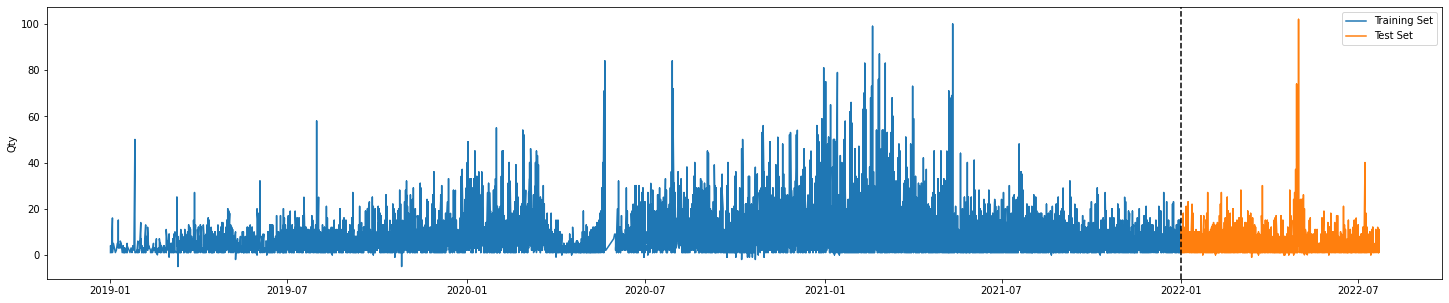

In [63]:
fig, ax = plt.subplots(figsize=(25, 5))
plt.plot(train['DATE1'], train['QTY'], label='Training Set')
plt.plot(test['DATE1'], test['QTY'], label='Test Set')
plt.ylabel('Qty')
plt.legend(['Training Set', 'Test Set'])
plt.axvline(pd.Timestamp('2022-01-01'), color='black', ls='--')
plt.show()

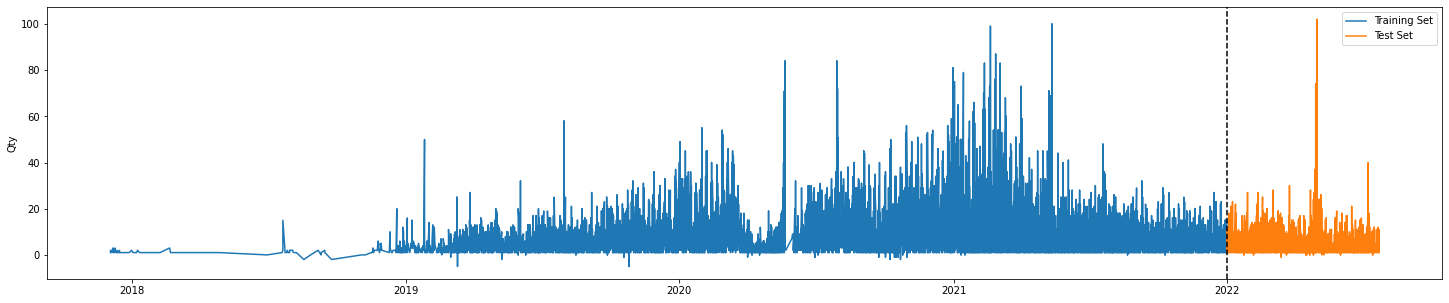

In [8]:
fig, ax = plt.subplots(figsize=(25, 5))
plt.plot(train['DATE1'], train['QTY'], label='Training Set')
plt.plot(test['DATE1'], test['QTY'], label='Test Set')
plt.ylabel('Qty')
plt.legend(['Training Set', 'Test Set'])
plt.axvline(pd.Timestamp('2022-01-01'), color='black', ls='--')
plt.show()

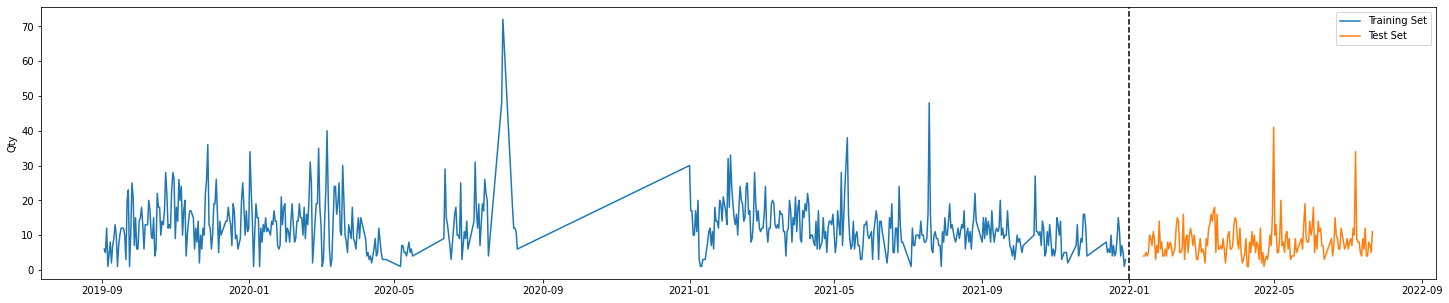

In [11]:
train58 = train.loc[train['SLS_CNTR_ID'] == 58]
test58 = test.loc[test['SLS_CNTR_ID'] == 58]
fig, ax = plt.subplots(figsize=(25, 5))
plt.plot(train58['DATE1'], train58['QTY'], label='Training Set')
plt.plot(test58['DATE1'], test58['QTY'], label='Test Set')
plt.ylabel('Qty')
plt.legend(['Training Set', 'Test Set'])
plt.axvline(pd.Timestamp('2022-01-01'), color='black', ls='--')
plt.show()

**Create the Model**

In [64]:
FEATURES = list(df.columns.values)
FEATURES.remove('DATE1')
FEATURES.remove('QTY')

In [65]:
FEATURES

['SLS_CNTR_ID',
 'dayofyear',
 'Monthday',
 'Weekday',
 'weekofyear',
 'month',
 'quarter',
 'isSalaryweek',
 'isWeekend',
 'isNationalday',
 'isRamadan',
 'isRamadanEnd',
 'isEid',
 'Holiday',
 'AcademicCalendarSemester',
 'Category_Brand',
 'Category_Brand2',
 'Category_Cancelled',
 'Category_HomeMade',
 'Category_HomeMadewithVAT',
 'Category_Imported',
 'Category_Itproducts',
 'Category_Local',
 'Category_Packaging',
 'Category_Partner',
 'Category_RawMaterial',
 'Category_SisterCompany',
 'hashedSKU']

In [66]:
#DataFrame.dtypes for data must be int, float or bool, so we are removing 'ITEM_ID' and 'DATE1'
#FEATURES = ['SLS_CNTR_ID', 'isSalaryweek', 'AcademicCalendarSemester', 'isWeekend', 'isRamadan', 'isRamadanEnd', 'isEid', 'isNationalday']
TARGET = 'QTY'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [79]:
model = xgb.XGBRegressor(base_score=0.05, booster='gbtree', 
                         min_child_weight=1,
                         random_state=5,   
                       n_estimators=800,
                       early_stopping_rounds=50,
                       objective='reg:squarederror', # instead of 'reg:linear' that is deprecated 
                       max_depth=7,
                       learning_rate=0.001)

In [80]:
model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:10.9794	validation_1-rmse:6.17416
[100]	validation_0-rmse:10.3112	validation_1-rmse:5.56641
[200]	validation_0-rmse:9.7274	validation_1-rmse:5.07175
[300]	validation_0-rmse:9.21518	validation_1-rmse:4.681
[400]	validation_0-rmse:8.76035	validation_1-rmse:4.38261
[500]	validation_0-rmse:8.3669	validation_1-rmse:4.16771
[600]	validation_0-rmse:8.03118	validation_1-rmse:4.03676
[700]	validation_0-rmse:7.7413	validation_1-rmse:3.96553
[799]	validation_0-rmse:7.49015	validation_1-rmse:3.9468


XGBRegressor(base_score=0.05, early_stopping_rounds=50, learning_rate=0.001,
             max_depth=7, n_estimators=800, objective='reg:squarederror',
             random_state=5)

In [83]:
test = test.drop(columns=['prediction'])

In [84]:
test['prediction'] = model.predict(X_test)

**Model RMSE score**

In [85]:
score = np.sqrt(mean_squared_error(test['QTY'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}') # 3.9468

RMSE Score on Test set: 3.95


In [86]:
explained_variance_score(test['QTY'], test['prediction']) # Best possible score is 1.0, lower values are worse

0.23597846863460015

In [87]:
r2_score(test['QTY'], test['prediction']) # 1.0 perfect, 0 impperfect

0.23463629248903228

In [88]:
median_absolute_error(test['QTY'], test['prediction']) # Best value is zero

1.48197603225708

**Calculate Error**

Look at the worst and best prediction days

In [89]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test['DATE1']
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(20)

date
2022-05-01    17.728508
2022-07-08     8.875150
2022-04-30     8.423556
2022-04-29     7.510031
2022-01-02     5.283080
2022-05-03     5.254393
2022-01-01     4.002499
2022-04-28     3.874528
2022-05-07     3.638348
2022-01-04     3.606155
2022-03-25     3.400878
2022-03-31     3.279686
2022-01-09     3.272791
2022-05-05     3.249778
2022-03-03     3.241835
2022-01-20     3.237270
2022-05-04     3.058255
2022-03-11     2.951922
2022-07-09     2.940067
2022-01-03     2.895452
Name: error, dtype: float64

Save the model

In [ ]:
with open(pathData + 'model.pk', 'wb') as f:
  pickle.dump(model, f)

In [ ]:
with open(pathData + '124766model.pk', 'wb') as f:
  pickle.dump(model, f)

**Feature Importance**

In [91]:
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d [%s], Score: %.5f' % (i, FEATURES[i], v))
#FEATURES = ['SLS_CNTR_ID', 'isSalaryweek', 'AcademicCalendarSemester', 'isWeekend', 'isRamadan', 'isRamadanEnd', 'isEid', 'isNationalday']

Feature: 0 [SLS_CNTR_ID], Score: 0.37317
Feature: 1 [dayofyear], Score: 0.07450
Feature: 2 [Monthday], Score: 0.01750
Feature: 3 [Weekday], Score: 0.06906
Feature: 4 [weekofyear], Score: 0.04463
Feature: 5 [month], Score: 0.17891
Feature: 6 [quarter], Score: 0.00000
Feature: 7 [isSalaryweek], Score: 0.00000
Feature: 8 [isWeekend], Score: 0.00525
Feature: 9 [isNationalday], Score: 0.07176
Feature: 10 [isRamadan], Score: 0.01174
Feature: 11 [isRamadanEnd], Score: 0.11774
Feature: 12 [isEid], Score: 0.00022
Feature: 13 [Holiday], Score: 0.00000
Feature: 14 [AcademicCalendarSemester], Score: 0.03552
Feature: 15 [Category_Brand], Score: 0.00000
Feature: 16 [Category_Brand2], Score: 0.00000
Feature: 17 [Category_Cancelled], Score: 0.00000
Feature: 18 [Category_HomeMade], Score: 0.00000
Feature: 19 [Category_HomeMadewithVAT], Score: 0.00000
Feature: 20 [Category_Imported], Score: 0.00000
Feature: 21 [Category_Itproducts], Score: 0.00000
Feature: 22 [Category_Local], Score: 0.00000
Feature: 23

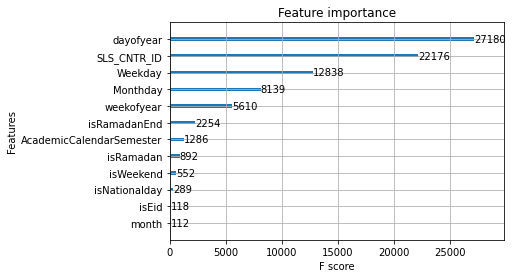

In [92]:
#from xgboost import XGBRegressor
from xgboost import plot_importance
# plot feature importance
plot_importance(model)
plt.show()

**Forecast on Test**

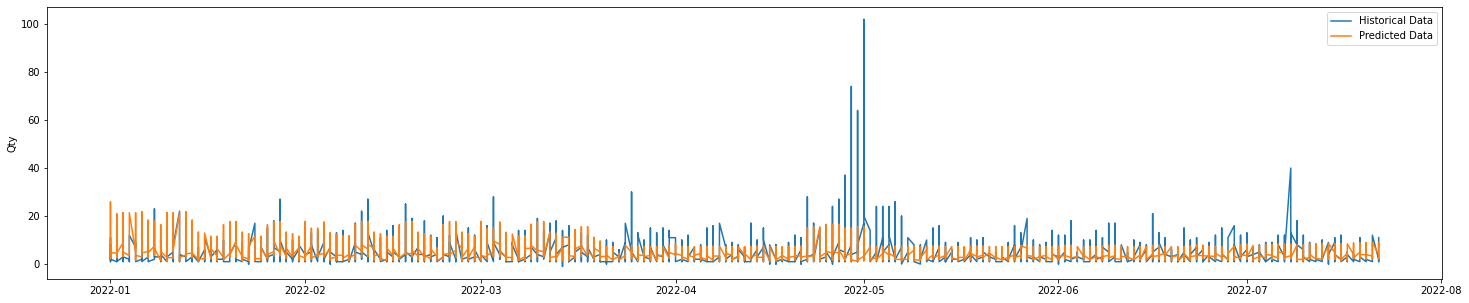

In [93]:
fig, ax = plt.subplots(figsize=(25, 5))
plt.plot(test['DATE1'], test['QTY'], label='Historical Data')
plt.plot(test['DATE1'], test['prediction'], label='Predicted Data')
plt.ylabel('Qty')
plt.legend(['Historical Data', 'Predicted Data'])
plt.show()

In [94]:
test

,SLS_CNTR_ID,DATE1,QTY,dayofyear,Monthday,Weekday,weekofyear,month,quarter,isSalaryweek,...,Category_Itproducts,Category_Local,Category_Packaging,Category_Partner,Category_RawMaterial,Category_SisterCompany,hashedSKU,prediction,error,date
397521,37,2022-01-01,8.0,1,1,5,52,1,1,0,...,0,1,0,0,0,0,44936676,7.718802,0.281198,2022-01-01
397520,34,2022-01-01,4.0,1,1,5,52,1,1,0,...,0,1,0,0,0,0,44936676,7.718802,3.718802,2022-01-01
397519,30,2022-01-01,4.0,1,1,5,52,1,1,0,...,0,1,0,0,0,0,44936676,5.005981,1.005981,2022-01-01
397518,28,2022-01-01,6.0,1,1,5,52,1,1,0,...,0,1,0,0,0,0,44936676,5.105567,0.894433,2022-01-01
397517,24,2022-01-01,7.0,1,1,5,52,1,1,0,...,0,1,0,0,0,0,44936676,8.743222,1.743222,2022-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399333,30,2022-07-22,5.0,203,22,4,29,7,3,0,...,0,1,0,0,0,0,44936676,3.163629,1.836371,2022-07-22
399334,34,2022-07-22,2.0,203,22,4,29,7,3,0,...,0,1,0,0,0,0,44936676,4.837345,2.837345,2022-07-22
399335,37,2022-07-22,1.0,203,22,4,29,7,3,0,...,0,1,0,0,0,0,44936676,3.934683,2.934683,2022-07-22
399324,4,2022-07-22,3.0,203,22,4,29,7,3,0,...,0,1,0,0,0,0,44936676,3.853583,0.853583,2022-07-22


In [ ]:
#use this if index is used
#span = test.loc[(test.index.get_level_values('DATE1') >= '2022-04-01') & (test.index.get_level_values('DATE1') < '2022-04-12') &
#                (test['SLS_CNTR_ID'] == 58)]

In [95]:
span = test.loc[(test['DATE1'] >= '2022-04-15') & (test['DATE1'] < '2022-05-15')]

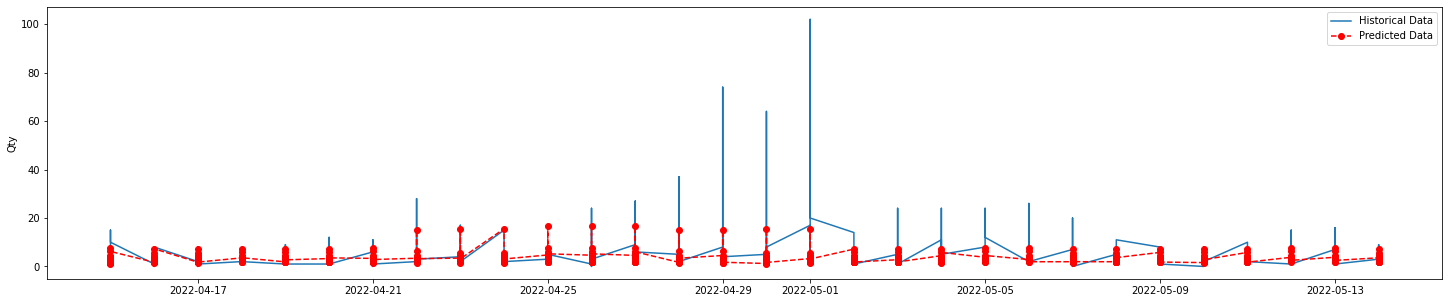

In [96]:
fig, ax = plt.subplots(figsize=(25, 5))

plt.plot(span['DATE1'], span['QTY'], label='Historical Data')
plt.plot(span['DATE1'], span['prediction'], marker='o', linestyle='--', color='r', label='Predicted Data')
plt.ylabel('Qty')
plt.legend(['Historical Data', 'Predicted Data'])
plt.show()

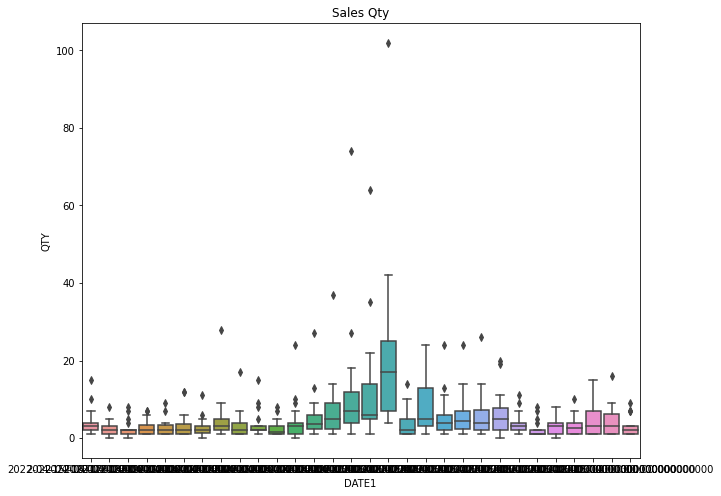

In [97]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=span, x='DATE1', y='QTY')
ax.set_title('Sales Qty')
plt.show()

In [98]:
span = test.loc[(test['DATE1'] >= '2022-04-15') & (test['DATE1'] < '2022-04-20')]

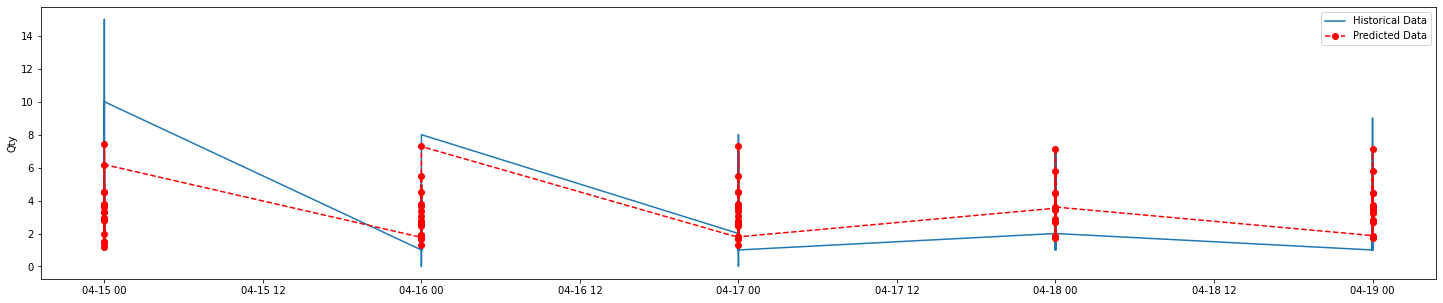

In [99]:
fig, ax = plt.subplots(figsize=(25, 5))

plt.plot(span['DATE1'], span['QTY'], label='Historical Data')
plt.plot(span['DATE1'], span['prediction'], marker='o', linestyle='--', color='r', label='Predicted Data')
plt.ylabel('Qty')
plt.legend(['Historical Data', 'Predicted Data'])
plt.show()

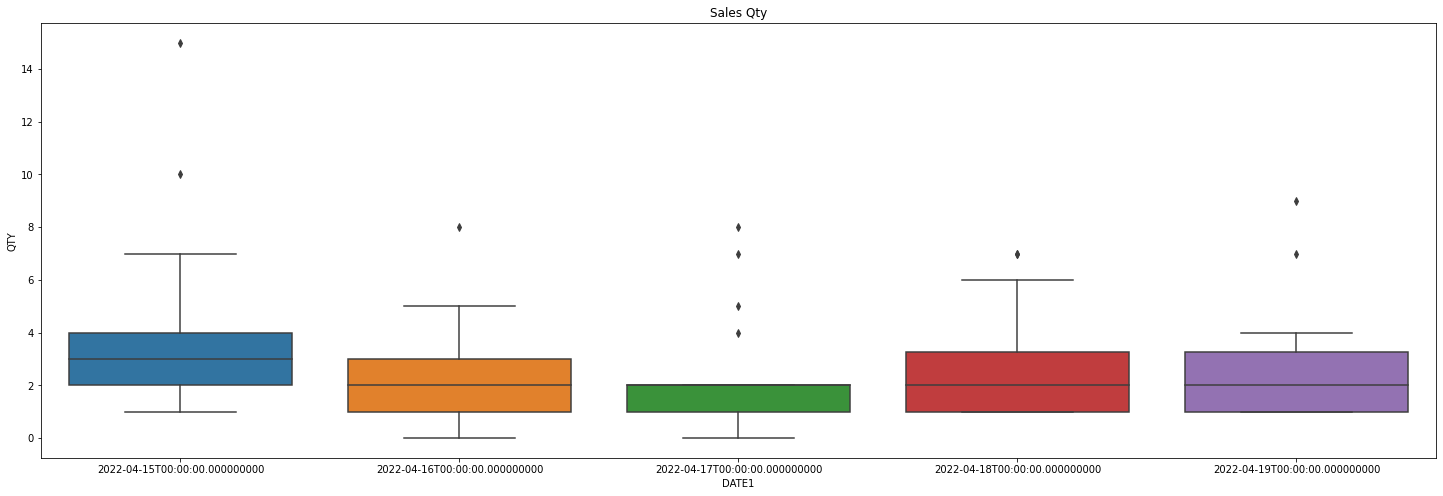

In [100]:
fig, ax = plt.subplots(figsize=(25, 8))
sns.boxplot(data=span, x='DATE1', y='QTY')
ax.set_title('Sales Qty')
plt.show()

In [101]:
span = test.loc[(test['DATE1'] >= '2022-04-15') & (test['DATE1'] < '2022-05-15') & (test['SLS_CNTR_ID'] == 58)]

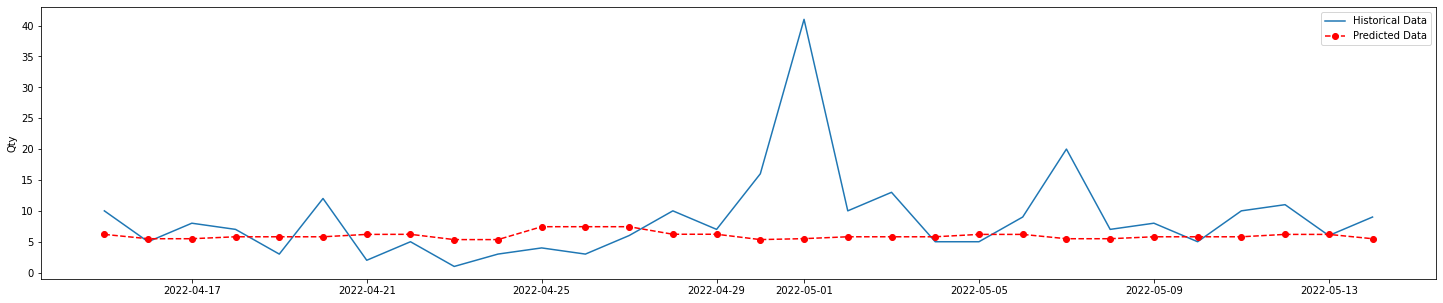

In [102]:
fig, ax = plt.subplots(figsize=(25, 5))

plt.plot(span['DATE1'], span['QTY'], label='Historical Data')
plt.plot(span['DATE1'], span['prediction'], marker='o', linestyle='--', color='r', label='Predicted Data')
plt.ylabel('Qty')
plt.legend(['Historical Data', 'Predicted Data'])
plt.show()